# Optimized Turnbull Driver

In [2]:
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
from matplotlib.backends.backend_pdf import PdfPages

from scipy.stats import truncnorm
from scipy.optimize import minimize

In [3]:
%run ../source/models/iceberg/iceberg.py
%run ../source/models/metocean/metocean.py
%run ../source/models/drift/turnbull.py
%run ../source/plotting/plot.py

In [4]:
chosen_track_ind = 0
iip_berg_df, iip_df, chosen_inds_arr = get_berg_df(2015, chosen_track_ind)
iip_berg_df

,index,ICEBERG_YEAR,ICEBERG_NUMBER,SIGHTING_DATE,SIGHTING_TIME,SIGHTING_LATITUDE,SIGHTING_LONGITUDE,SIGHTING_METHOD,SIZE,SHAPE,SOURCE,TIMESTAMP
0,6319,2015,21511,6/16/2015,1442,48.16,-50.01,R/V,LG,TAB,GTJZ,2015-06-16 14:42:00
1,6320,2015,21511,6/17/2015,1300,48.09,-50.02,R/V,LG,GEN,GMRS,2015-06-17 13:00:00
2,6321,2015,21511,6/18/2015,1249,48.08,-49.76,VIS,LG,TAB,GTJZ,2015-06-18 12:49:00


In [5]:
chosen_inds_arr.sort(key=len, reverse=True)
iip_berg_df = iip_df.loc[chosen_inds_arr[0]].reset_index()
iip_berg_df

,index,ICEBERG_YEAR,ICEBERG_NUMBER,SIGHTING_DATE,SIGHTING_TIME,SIGHTING_LATITUDE,SIGHTING_LONGITUDE,SIGHTING_METHOD,SIZE,SHAPE,SOURCE,TIMESTAMP
0,10822,2015,23525,6/24/2015,1306,47.71,-49.50,R/V,LG,GEN,GTJZ,2015-06-24 13:06:00
1,10823,2015,23525,6/25/2015,1118,47.55,-49.41,R/V,LG,GEN,GTJZ,2015-06-25 11:18:00
2,10824,2015,23525,6/25/2015,1918,47.49,-49.44,R/V,LG,GEN,GPGR,2015-06-25 19:18:00
3,10825,2015,23525,6/26/2015,1046,47.46,-49.45,R/V,GEN,GEN,GTJZ,2015-06-26 10:46:00
4,10826,2015,23525,6/26/2015,1636,47.43,-49.44,R/V,LG,GEN,GMRS,2015-06-26 16:36:00
5,10827,2015,23525,6/27/2015,1105,47.38,-49.47,R/V,LG,GEN,GPGR,2015-06-27 11:05:00
6,10828,2015,23525,6/27/2015,1331,47.35,-49.49,RAD,GEN,GEN,2005,2015-06-27 13:31:00


In [6]:
iip_berg = Iceberg(iip_berg_df['ICEBERG_NUMBER'].loc[0],
                    iip_berg_df['TIMESTAMP'].dt.to_pydatetime(),
                    [0], [0],
                    iip_berg_df['SIGHTING_LATITUDE'].loc[:].tolist(),
                    iip_berg_df['SIGHTING_LONGITUDE'].loc[:].tolist(),
                    iip_berg_df['SIZE'].loc[0],
                    iip_berg_df['SHAPE'].loc[0])

In [7]:
ocean_data = ECMWF_Ocean(min(iip_berg.lons), max(iip_berg.lons),
                         min(iip_berg.lats), max(iip_berg.lats),
                         iip_berg.datetimes[0], iip_berg.datetimes[-1])

In [8]:
atm_data = ECMWF_Atm(min(iip_berg.lons), max(iip_berg.lons),
                     min(iip_berg.lats), max(iip_berg.lats),
                     iip_berg.datetimes[0], iip_berg.datetimes[-1])

In [33]:
def optimize_turnbull(params):
    
    # params = [Ca, Cw, l, w, h, vx0, vy0]
    
    assert(len(params) == 7)
    
    Ca = params[0]
    Cw = params[1]
    l = params[2]
    w = params[3]
    h = params[4]
    vx0 = params[5]
    vy0 = params[6]

    # Buffer number for bounding spatial box
    buf = 0.5


    # Create model iceberg
    mod_berg = Iceberg(iip_berg_df['ICEBERG_NUMBER'][0],
                        [iip_berg_df['TIMESTAMP'].dt.to_pydatetime()[0]],
                        [0], [0],
                        [iip_berg_df['SIGHTING_LATITUDE'][0]],
                        [iip_berg_df['SIGHTING_LONGITUDE'][0]],
                        iip_berg_df['SIZE'][0], iip_berg_df['SHAPE'].loc[0])

    mod_berg.air_drag_coeff = Ca
    mod_berg.water_drag_coeff = Cw
    
    mod_berg.length = [l]
    mod_berg.width = [w]
    mod_berg.height = [h]
    
    mod_berg.xvels[0] = vx0
    mod_berg.yvels[0] = vy0
    

    # Timesteps
    t0 = iip_berg.datetimes[0]
    tf = iip_berg.datetimes[-1]
    t_delta = tf - t0
    t_delta_hours = t_delta.days*24 + t_delta.seconds/3600
    t_step_hours = 0.1
    t_step = timedelta(hours = t_step_hours)
    dt = t_step_hours*3600  # timestep in seconds
    t_all = []
    for i in np.arange(0, t_delta_hours + t_step_hours, t_step_hours):
        new_date = t0 + timedelta(hours=i)
        t_all.append(new_date)



    # Iceberg Initials
    x0, y0 = mod_berg.lons[0], mod_berg.lats[0]
    l0, w0, h0 = mod_berg.length[0], mod_berg.width[0], mod_berg.height[0]

    l, w, h = l0, w0, h0
    x, y = x0, y0
    vx, vy = vx0, vy0


    for t in t_all:


        t_ocean = nc.date2num(t, 'hours since 1950-01-01 00:00:00.0 00:00', 'standard')
        t_atm = nc.date2num(t, 'hours since 1900-01-01 00:00:00.0 00:00', 'standard')

        vau = atm_data.iUA([t_atm, y, x])[0]
        vav = atm_data.iVA([t_atm, y, x])[0]
        vwu = ocean_data.iUW([t_ocean, y, x])[0]
        vwv = ocean_data.iVW([t_ocean, y, x])[0]


        vx, vy, x, y = turnbull_drift(mod_berg, vau, vav, vwu, vwv, dt) 


        if x > max(iip_berg.lons)+buf or x < min(iip_berg.lons)-buf or y > max(iip_berg.lats)+buf or y < min(iip_berg.lats)-buf:
            # Iceberg out-of-bounds
            print('out-of-bounds')
            break


        else:
            mod_berg.xvels.append(vx)
            mod_berg.yvels.append(vy)
            mod_berg.lons.append(x)
            mod_berg.lats.append(y)
            mod_berg.datetimes.append(t)

            
    all_iip_times = []
    for iip_datetime in iip_berg.datetimes:
        all_iip_times.append(round((iip_datetime - iip_berg.datetimes[0]).total_seconds()/3600,1))
    all_iip_times = np.asarray(all_iip_times)
    
    all_mod_times = []
    for mod_datetime in mod_berg.datetimes:
        all_mod_times.append(round((mod_datetime - mod_berg.datetimes[0]).total_seconds()/3600,1))
    all_mod_times = np.asarray(all_mod_times)

    time_inds = []
    for j in range(all_iip_times.size):
        if np.any(all_mod_times == all_iip_times[j]):
            time_inds.append(np.where(all_mod_times == all_iip_times[j])[0][0])
                        
    all_xy_mse = []
    counter = 0
    for iip_time_ind, mod_time_ind in enumerate(time_inds):
        xy_mse = np.sqrt((mod_berg.lons[mod_time_ind] - iip_berg.lons[iip_time_ind])**2 + (mod_berg.lats[mod_time_ind] - iip_berg.lats[iip_time_ind])**2)
        all_xy_mse.append(xy_mse)
       
    avg_xy_mse = np.mean(all_xy_mse)
    
    return avg_xy_mse

In [10]:
optimize_turnbull([0.25, 2.25, 125, 174, 288, 0.004, -0.022])

0.12077261887666989

In [74]:
minimize(optimize_turnbull, 
         x0 = [0.25, 2.25, 125, 174, 288, 0.004, -0.022], 
         method = 'TNC', options = {'ftol': 1e-2},
         bounds = ((0.01, 0.5), (2.0, 2.5), (120, 200), (120, 200), (200, 400), (0.0, 0.05), (-0.05, 0.0)))

     fun: 0.12683009052032596
     jac: array([  70628.98493886, -292459.37785281,   64132.30520577,
       -244415.17015657,  439122.39632295, -301111.61655886,
        278293.6926238 ])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 9
     nit: 1
  status: 1
 success: True
       x: array([  2.50000000e-01,   2.25000000e+00,   1.25000000e+02,
         1.74000000e+02,   2.88000000e+02,   4.00000000e-03,
        -2.20000000e-02])

In [49]:
def get_surf_plot_data(optimize_turnbull):
    surf_plot_data = {'Ca': None, 'Cw': None, 'fval': None}
    lb = 0.5; ub = 2.5; inc = 0.25
    Ca = np.arange(lb, ub+inc, inc)
    Cw = np.arange(lb, ub+inc, inc)
    surf_plot_data['fval'] = np.empty((len(Ca), len(Cw)))
    for i in range(len(Cw)):
        for j in range(len(Ca)):
            surf_plot_data['fval'][i][j] = optimize_turnbull([Ca[j], Cw[i], 125, 174, 288, 0.004, -0.022])
    Ca, Cw = np.meshgrid(Ca, Cw)
    surf_plot_data['Ca']= Ca; surf_plot_data['Cw'] = Cw
    return surf_plot_data

In [50]:
surf_plot_data = get_surf_plot_data(optimize_turnbull)

In [51]:
surf_plot_data['Ca']

array([[ 0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,  2.25,  2.5 ],
       [ 0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,  2.25,  2.5 ],
       [ 0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,  2.25,  2.5 ],
       [ 0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,  2.25,  2.5 ],
       [ 0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,  2.25,  2.5 ],
       [ 0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,  2.25,  2.5 ],
       [ 0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,  2.25,  2.5 ],
       [ 0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,  2.25,  2.5 ],
       [ 0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,  2.25,  2.5 ]])

In [52]:
surf_plot_data['Cw']

array([[ 0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.5 ],
       [ 0.75,  0.75,  0.75,  0.75,  0.75,  0.75,  0.75,  0.75,  0.75],
       [ 1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ],
       [ 1.25,  1.25,  1.25,  1.25,  1.25,  1.25,  1.25,  1.25,  1.25],
       [ 1.5 ,  1.5 ,  1.5 ,  1.5 ,  1.5 ,  1.5 ,  1.5 ,  1.5 ,  1.5 ],
       [ 1.75,  1.75,  1.75,  1.75,  1.75,  1.75,  1.75,  1.75,  1.75],
       [ 2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ],
       [ 2.25,  2.25,  2.25,  2.25,  2.25,  2.25,  2.25,  2.25,  2.25],
       [ 2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ]])

In [53]:
surf_plot_data['fval']

array([[ 0.16654154,  0.16040279,  0.14567035,  0.14126974,  0.09564348,
         0.10141722,  0.11058877,  0.09136938,  0.08937047],
       [ 0.13883084,  0.13298432,  0.13862877,  0.10397926,  0.09862268,
         0.1019756 ,  0.0989752 ,  0.09695795,  0.10466519],
       [ 0.14360681,  0.13457645,  0.12544384,  0.10307047,  0.10125342,
         0.10038953,  0.1089815 ,  0.10379809,  0.10044061],
       [ 0.12740922,  0.12213982,  0.12244928,  0.10523351,  0.10772781,
         0.10354284,  0.10685072,  0.10740214,  0.1185092 ],
       [ 0.12942521,  0.11365211,  0.10809649,  0.10720768,  0.1065857 ,
         0.10322661,  0.10821385,  0.10897884,  0.12552631],
       [ 0.12812527,  0.12077562,  0.10878111,  0.10881396,  0.112918  ,
         0.10467985,  0.12149946,  0.12341513,  0.11644019],
       [ 0.11685952,  0.11780564,  0.1105015 ,  0.10813856,  0.11682586,
         0.10592854,  0.10489962,  0.11678826,  0.11580704],
       [ 0.12148357,  0.11495493,  0.11304077,  0.11031298,  0

In [54]:
def make_surf_plot(surf_plot_data):
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    X = surf_plot_data['Ca']
    Y = surf_plot_data['Cw']
    Z = np.array(surf_plot_data['fval'])

    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)
        
    ax.set_xlabel('Ca')
    ax.set_ylabel('Cw')
    ax.set_zlabel('MSE')    
    plt.show()
    plt.savefig('plots/surf_plot.png')

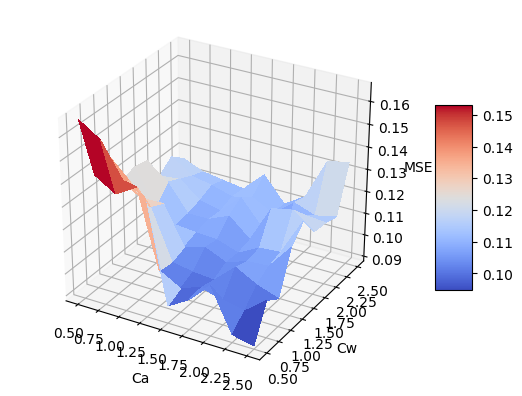

In [55]:
make_surf_plot(surf_plot_data)